In [36]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy.integrate import solve_ivp

module = os.path.abspath(os.path.join('../../src'))
if module not in sys.path:
    sys.path.append(module)
from earth import Earth
from utils import get_form_initial_conditions

In [37]:
n_p = 3
n_x = 6
# mu = Earth().mu
mu = 1.0

def function(p_vec):
    p_norm = np.linalg.norm(p_vec)
    return -mu * p_vec / p_norm**3

def first_order_partial_derivatives(p_vec):
    n = len(p_vec)
    p_norm = np.linalg.norm(p_vec)
    return -mu * (np.eye(n) / p_norm**3 - 3 * np.outer(p_vec, p_vec) / p_norm**5)

def second_order_partial_derivatives(p_vec):
    n = len(p_vec)
    p_norm = np.linalg.norm(p_vec)
    return -mu * (-3 / p_norm**5 * (np.outer(np.eye(n), p_vec) + np.kron(np.eye(n), p_vec) + np.kron(p_vec, np.eye(n))) + 15 / p_norm**7 * np.kron(p_vec, np.outer(p_vec, p_vec))) 

def total_differential_equation(x_vec):
    n = len(x_vec)
    x_dot_vec = np.zeros_like(x_vec)
    for i in range(n // n_x):
        p_vec = x_vec[i * n_x : i * n_x + n_p] 
        v_vec = x_vec[i * n_x + n_p : i * n_x + n_x]
        x_dot_vec[i * n_x : i * n_x + n_x] = np.concatenate((v_vec, function(p_vec)))
    return x_dot_vec

def total_first_order_partial_derivatives_for_the_differential_equation(x_vec):
    n = len(x_vec)
    first_order_der = np.zeros((n, n))
    for i in range(n // n_x):
        p_vec = x_vec[i * n_x : i * n_x + n_p]
        first_order_der[i * n_x : i * n_x + n_p, i * n_x + 3 : i * n_x + n_x] = np.eye(n_p)
        first_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p] = first_order_partial_derivatives(p_vec)
    return first_order_der

def total_second_order_partial_derivatives_for_the_differential_equation(x_vec):
    n = len(x_vec)
    second_order_der = np.zeros((n, n, n))
    for i in range(n // n_x):
        p_vec = x_vec[i * n_x : i * n_x + 3]
        aux = second_order_partial_derivatives(p_vec).reshape(n_p, n_p, n_p)
        for j in range(n_p): 
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p, i * n_x + j] = aux[:, :, j]
    return second_order_der.reshape((n * n, n))

def f(dt, x_old):
    k1 = total_differential_equation(x_old)
    k2 = total_differential_equation(x_old + dt / 2 * k1)
    k3 = total_differential_equation(x_old + dt / 2 * k2)
    k4 = total_differential_equation(x_old + dt * k3)
    return x_old + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

def Df(dt, x_old):
    n = len(x_old)
    
    k1 = total_differential_equation(x_old)
    k2 = total_differential_equation(x_old + dt / 2 * k1)
    k3 = total_differential_equation(x_old + dt / 2 * k2)

    Dk1 = total_first_order_partial_derivatives_for_the_differential_equation(x_old)
    Dk2 = total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)
    Dk4 = total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3) @ (np.eye(n) + dt * Dk3)
    return np.eye(n) + dt / 6 * (Dk1 + 2 * Dk2 + 2 * Dk3 + Dk4)

def Hf(dt, x_old):
    n = len(x_old)
    
    k1 = total_differential_equation(x_old)
    k2 = total_differential_equation(x_old + dt / 2 * k1)
    k3 = total_differential_equation(x_old + dt / 2 * k2)

    Dk1 = total_first_order_partial_derivatives_for_the_differential_equation(x_old)
    Dk2 = total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)

    Hk1 = total_second_order_partial_derivatives_for_the_differential_equation(x_old)
    Hk2 = np.kron(np.eye(n), np.eye(n) + dt / 2 * Dk1).T @ total_second_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1) + np.kron(total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1), np.eye(n)) @ (dt / 2 * Hk1)
    Hk3 = np.kron(np.eye(n), np.eye(n) + dt / 2 * Dk2).T @ total_second_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2) + np.kron(total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2), np.eye(n)) @ (dt / 2 * Hk2)
    Hk4 = np.kron(np.eye(n), np.eye(n) + dt * Dk3).T @ total_second_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3) @ (np.eye(n) + dt * Dk3) + np.kron(total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3), np.eye(n)) @ (dt * Hk3)
    return dt / 6 * (Hk1 + 2 * Hk2 + 2 * Hk3 + Hk4)

In [38]:
o = 9

def h(x_vec):
    n = len(x_vec)
    p_vecs = [x_vec[i : i + n_p] for i in range(0, n, n_x)]
    distances = [np.linalg.norm(p_vecs[j] - p_vecs[i]) for (i, j) in [(1, 0), (1, 2), (1, 3), (2, 0), (2, 3), (3, 0)]]
    return np.concatenate((p_vecs[0], np.array(distances).reshape(-1, 1)))

def Dh(x_vec):
    n = len(x_vec)
    first_order_der = np.zeros((o, n))
    p_vecs = [x_vec[i : i + n_p] for i in range(0, n, n_x)]
    
    first_order_der[:n_p, :n_p] = np.eye(n_p)
    
    for k, (i, j) in enumerate([(1, 0), (1, 2), (1, 3), (2, 0), (2, 3), (3, 0)], start=n_p):
        d = p_vecs[j] - p_vecs[i]
        norm_d = np.linalg.norm(d)
        first_order_der[k, i * n_x : i * n_x + n_p] = -d.T / norm_d
        first_order_der[k, j * n_x : j * n_x + n_p] = d.T / norm_d
    
    return first_order_der

def Hh(x_vec):
    n = len(x_vec)
    second_order_der = np.zeros((o, n, n))
    p_vecs = [x_vec[i : i + n_p] for i in range(0, n, n_x)]

    def hessian_distance(d, norm_d):
        I = np.eye(n_p)
        return -(I / norm_d - np.outer(d, d) / norm_d**3)

    for k, (i, j) in enumerate([(1, 0), (1, 2), (1, 3), (2, 0), (2, 3), (3, 0)], start=n_p):
        d = p_vecs[j] - p_vecs[i]
        norm_d = np.linalg.norm(d)
        hess_d = hessian_distance(d, norm_d)
        
        second_order_der[k, i * n_x : i * n_x + n_p, i * n_x : i * n_x + n_p] = -hess_d
        second_order_der[k, i * n_x : i * n_x + n_p, j * n_x : j * n_x + n_p] = hess_d
        second_order_der[k, j * n_x : j * n_x + n_p, i * n_x : i * n_x + n_p] = hess_d
        second_order_der[k, j * n_x : j * n_x + n_p, j * n_x : j * n_x + n_p] = -hess_d
    
    return second_order_der.reshape((o * n, n))

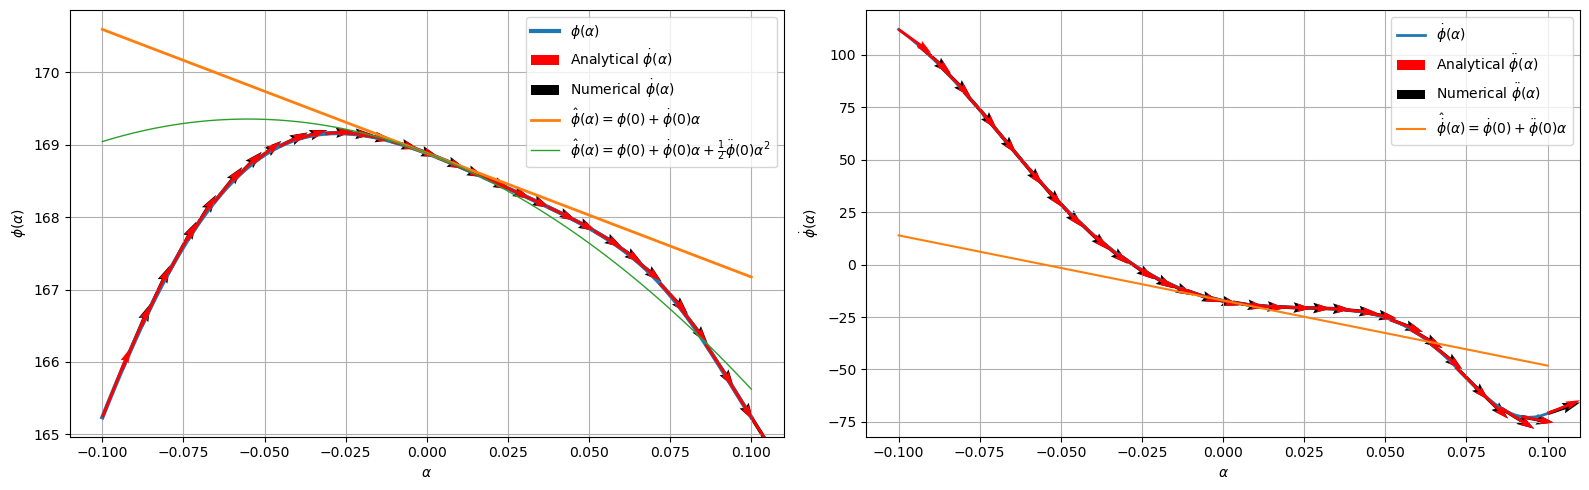

In [43]:
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

def cost_function(tau, dt, y, x_vec): # For the initial conditions, for now
    for _ in range(tau):
        x_vec = f(dt, x_vec)
    return 1 / 2 * (y - h(x_vec)).T @ np.linalg.inv(R) @ (y - h(x_vec))

def cost_function_grad(tau, dt, y, x_vec):
    n = len(x_vec)
    STM = np.eye(n)
    for _ in range(tau):
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    return -STM.T @ Dh(x_vec).T @ np.linalg.inv(R) @ (y - h(x_vec))

def cost_function_hessian(tau, dt, y, x_vec):
    n = len(x_vec)
    o = len(y)
    STM = np.eye(n)
    DSTM = np.zeros((n * n, n))
    for _ in range(tau):
        DSTM = np.kron(np.eye(n), STM).T @ Hf(dt, x_vec) @ STM + np.kron(Df(dt, x_vec), np.eye(n)) @ DSTM
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    
    Df_x = STM
    Hf_x = DSTM    
    h_x = h(x_vec)
    Dh_x = Dh(x_vec)
    Hh_x = Hh(x_vec)
    R_inv = np.linalg.inv(R)
    return - (np.kron(R_inv @ (y - h_x), Df_x).T @ Hh_x @ Df_x + np.kron(Dh_x.T @ R_inv @ (y - h_x), np.eye(n)).T @ Hf_x) + Df_x.T @ Dh_x.T @ R_inv @ Dh_x @ Df_x

def test_function(tau, dt, y, p, alpha, x_vec):
    return cost_function(tau, dt, y, p + alpha * x_vec)

def test_function_grad(tau, dt, y, p, alpha, x_vec):
    return cost_function_grad(tau, dt, y, p + alpha * x_vec).T @ x_vec

def test_function_hessian(tau, dt, y, p, alpha, x_vec):
    return x_vec.T @ cost_function_hessian(tau, dt, y, p + alpha * x_vec) @ x_vec

def test_function_approx_first_order(tau, dt, y, p, alpha, x_vec):
    return test_function(tau, dt, y, p, 0, x_vec) + test_function_grad(tau, dt, y, p, 0, x_vec) * alpha

def test_function_approx_second_order(tau, dt, y, p, alpha, x_vec):
    return test_function(tau, dt, y, p, 0, x_vec) + test_function_grad(tau, dt, y, p, 0, x_vec) * alpha + 1/2 * test_function_hessian(tau, dt, y, p, 0, x_vec) * alpha**2

def test_function_grad_approx_first_order(tau, dt, y, p, alpha, x_vec):
    return test_function_grad(tau, dt, y, p, 0, x_vec) + test_function_hessian(tau, dt, y, p, 0, x_vec) * alpha

std = 1e0
np.random.seed(42)
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(24,), cov=std*np.eye(24)).reshape((24, 1))
p = np.random.multivariate_normal(mean=np.zeros(24,), cov=std*np.eye(24)).reshape((24, 1))
# sample_x_vec = get_form_initial_conditions(1)

tau = 3
dt = 1.0
# dt = 60.0
y = np.random.multivariate_normal(mean=np.zeros(9,), cov=std*np.eye(9)).reshape((9, 1))
# y = h(sample_x_vec) + np.random.multivariate_normal(mean=np.zeros(9,), cov=R).reshape((9, 1))

aux = 1e-1
alpha_bounds = np.linspace(-aux, aux, 100)
cost_values = np.array([test_function(tau, dt, y, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(tau, dt, y, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([test_function_hessian(tau, dt, y, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function = np.array([test_function_approx_first_order(tau, dt, y, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_test_function = np.array([test_function_approx_second_order(tau, dt, y, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function_grad = np.array([test_function_grad_approx_first_order(tau, dt, y, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])

# Arrows arrows
num_arrows = 30
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

def compute_tangent_slope(x, y, idx):
    """Compute the slope of the tangent line at a given index idx."""
    if idx == 0:
        slope = (y[idx + 1] - y[idx]) / (x[idx + 1] - x[idx])
    elif idx == len(x) - 1:
        slope = (y[idx] - y[idx - 1]) / (x[idx] - x[idx - 1])
    else:
        slope = (y[idx + 1] - y[idx - 1]) / (x[idx + 1] - x[idx - 1])

    return slope

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Function and gradient arrows
axes[0].plot(alpha_bounds, cost_values, label=r'$\phi(\alpha)$', linewidth=3)
axes[0].quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], 
               np.ones_like(arrow_indices), gradient_values[arrow_indices], 
               angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\dot{\phi}(\alpha)$')
axes[0].quiver(alpha_bounds[arrow_indices][1:], cost_values[arrow_indices][1:],
                np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, cost_values, idx) for idx in arrow_indices])[1:],
                angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\dot{\phi}(\alpha)$')
axes[0].plot(alpha_bounds, taylor_series_first_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha$', zorder=3, linewidth=2)
axes[0].plot(alpha_bounds, taylor_series_second_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha + \frac{1}{2}\ddot{\phi}(0)\alpha^2$', zorder=3, linewidth=1)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$\phi(\alpha)$')
axes[0].grid()
axes[0].legend()

# Right plot: Gradient and Hessian arrows
axes[1].plot(alpha_bounds, gradient_values, label=r'$\dot{\phi}(\alpha)$', linewidth=2)
axes[1].quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], 
               np.ones_like(arrow_indices), hessian_values[arrow_indices], 
               angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\ddot{\phi}(\alpha)$')
axes[1].quiver(alpha_bounds[arrow_indices][1:], gradient_values[arrow_indices][1:], 
               np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, gradient_values, idx) for idx in arrow_indices])[1:], 
               angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\ddot{\phi}(\alpha)$')
axes[1].plot(alpha_bounds, taylor_series_first_order_expansion_test_function_grad, label=r'$\hat{\dot{\phi}}(\alpha) = \dot{\phi}(0) + \ddot{\phi}(0)\alpha$', zorder=3)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\dot{\phi}(\alpha)$')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()